In [1]:
from sklearn.svm import SVR #SVM임포트
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from google.colab import drive #구글 드라이브 연결
from pandas_datareader import data as pdr
from sklearn.metrics import mean_squared_error, r2_score

In [2]:
def preprocess_stock_data(df):
    # 누락된 값 처리
    df.fillna(method='ffill', inplace=True)

    # 너무 큰 값 수정
    threshold = 1.5  # 예시로 임의의 임계값 설정
    for column in df.columns:
        for i in range(1, len(df)):
            if abs(df[column][i] - df[column][i - 1]) > threshold * df[column][i - 1]:
                # 너무 큰 값이면 이전 값으로 대체
                df.at[i, column] = df.at[i - 1, column]

    return df

In [3]:
# 트레이닝 데이터 불러오기
filename = '/content/drive/MyDrive/Given Data_10/06.xlsx'
df = pd.read_excel(filename, engine='openpyxl')
df.drop('Date', axis=1, inplace=True)
processed_df = preprocess_stock_data(df)
print(processed_df)

       Open    High     Low   Close      Adj Close   Volume
0    121000  121000  118000  118000  107800.984375   556532
1    118500  119000  115000  116000  105973.867188  1145187
2    116000  117000  115500  116000  105973.867188   334574
3    116500  117000  115500  115500  105517.078125   674196
4    115000  115500  111500  112000  102319.585938  1044825
..      ...     ...     ...     ...            ...      ...
938  186900  187000  181400  182800  182800.000000        0
939  182700  183700  182000  182000  182000.000000        0
940  180300  182500  178500  179500  179500.000000        0
941  181200  182900  174600  175600  175600.000000        0
942  175000  176300  171400  172500  172500.000000        0

[943 rows x 6 columns]


In [4]:
fin = processed_df.tail(500) #데이터 전체

stock_HL = fin[['High','Low']].mean(axis=1) #최고가,최저가 평균
stock_HL = stock_HL.values

In [5]:
days = [] #임의로 데이터당 숫자 지정
for i in range(len(fin)):
  days.append([int(i)])
  i=i+1

In [14]:
# 가중치 설정을 위한 배열 생성
weights = np.ones(len(stock_HL))
weights[:800] = 0.7

In [15]:
#stock_HL
lin_svr_HL = SVR(kernel='linear', C=7000) #커널을 linear로 설정
lin_svr_HL.fit(days,stock_HL,sample_weight=weights)

poly_svr_HL = SVR(kernel='poly', C=7000, degree=5, coef0=1.0) #커널을 poly로 설정
poly_svr_HL.fit(days,stock_HL,sample_weight=weights)

rbf_svr_HL = SVR(kernel='rbf',C=70000,gamma=0.2) #커널을 rbf로 설정
rbf_svr_HL.fit(days,stock_HL,sample_weight=weights)

SVR(C=70000, gamma=0.2)

In [16]:
day = np.array([[len(fin) + 1]])

lin_HL_predictions = lin_svr_HL.predict(day)
poly_HL_predictions = poly_svr_HL.predict(day)
rbf_HL_predictions = rbf_svr_HL.predict(day)

In [17]:
print('다음 날 예측 (linear,HL): ', lin_HL_predictions)
print('다음 날 예측 (polynomial,HL): ', poly_HL_predictions)
print('다음 날 예측 (RBF,HL): ', rbf_HL_predictions)

다음 날 예측 (linear,HL):  [187465.81297449]
다음 날 예측 (polynomial,HL):  [175413.53319552]
다음 날 예측 (RBF,HL):  [176891.55096967]


In [18]:
final_prediction = (lin_HL_predictions + poly_HL_predictions + rbf_HL_predictions) / 3 #모델3개값 평균값
print('최종 예측 값:',final_prediction)

최종 예측 값: [179923.63237989]


HL

In [19]:
#MSE
# 실제 다음 날 종가 값
actual_next_day_close = df.iloc[-1]['Close']

# 각 모델의 예측값과 실제값 간의 MSE 계산
lin_HL_mse = mean_squared_error([actual_next_day_close], lin_HL_predictions)
poly_HL_mse = mean_squared_error([actual_next_day_close], poly_HL_predictions)
rbf_HL_mse = mean_squared_error([actual_next_day_close], rbf_HL_predictions)

print('Linear 모델 MSE:', lin_HL_mse)
print('Polynomial 모델 MSE:', poly_HL_mse)
print('RBF 모델 MSE:', rbf_HL_mse)

Linear 모델 MSE: 223975557.98735377
Polynomial 모델 MSE: 8488675.68137711
RBF 모델 MSE: 19285719.91922488


In [20]:
#R2
lin_HL_predictionss = lin_svr_HL.predict(days)
poly_HL_predictionss = poly_svr_HL.predict(days)
rbf_HL_predictionss = rbf_svr_HL.predict(days)

lin_HL_r2 = r2_score(stock_HL, lin_HL_predictionss, sample_weight=weights)
poly_HL_r2 = r2_score(stock_HL, poly_HL_predictionss, sample_weight=weights)
rbf_HL_r2 = r2_score(stock_HL, rbf_HL_predictionss, sample_weight=weights)

print('R2 스코어 (linear): ', lin_HL_r2)
print('R2 스코어 (polynomial): ', poly_HL_r2)
print('R2 스코어 (RBF): ', rbf_HL_r2)

R2 스코어 (linear):  -0.01890955713176501
R2 스코어 (polynomial):  0.4616914063812141
R2 스코어 (RBF):  0.996889917038622


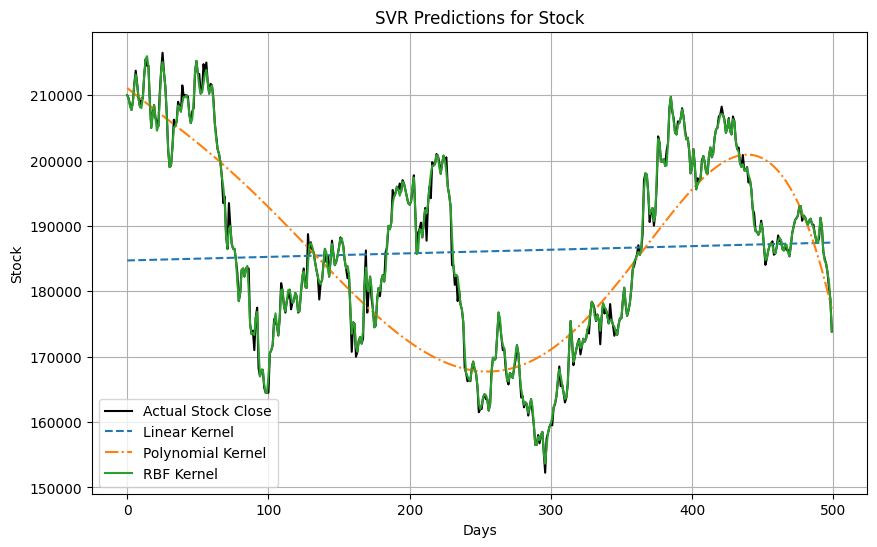

In [21]:
new_days = np.arange(len(fin))

# 예측값의 길이를 new_days와 동일하도록 조정
lin_HL_predictions.reshape(-1, 1)
poly_HL_predictions.reshape(-1, 1)
rbf_HL_predictions.reshape(-1, 1)

plt.figure(figsize=(10, 6))
plt.plot(days, stock_HL, label='Actual Stock Close', color='black')

plt.plot(new_days, lin_HL_predictionss, label='Linear Kernel', linestyle='--')
plt.plot(new_days, poly_HL_predictionss, label='Polynomial Kernel', linestyle='-.')
plt.plot(new_days, rbf_HL_predictionss, label='RBF Kernel', linestyle='-')

plt.xlabel('Days')
plt.ylabel('Stock')
plt.title('SVR Predictions for Stock')
plt.legend()
plt.grid(True)
plt.show()

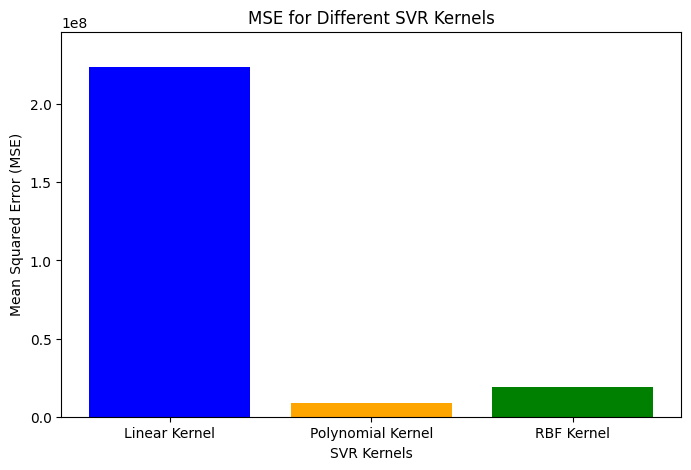

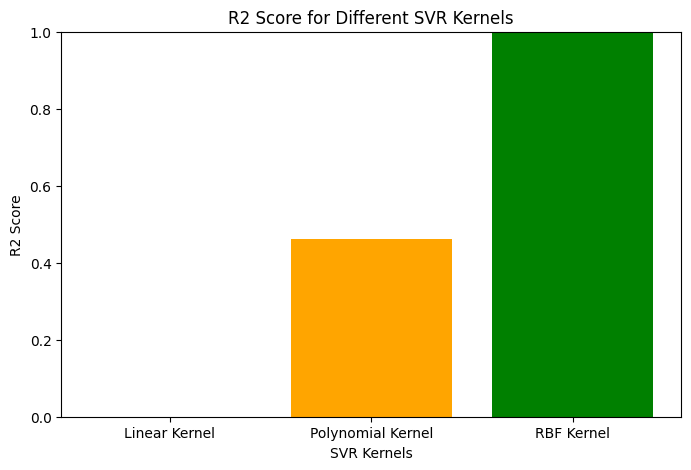

In [24]:
# 예측 성능 시각화 - MSE
models = ['Linear Kernel', 'Polynomial Kernel', 'RBF Kernel']
mse_values = [lin_HL_mse, poly_HL_mse, rbf_HL_mse]

plt.figure(figsize=(8, 5))
plt.bar(models, mse_values, color=['blue', 'orange', 'green'])
plt.xlabel('SVR Kernels')
plt.ylabel('Mean Squared Error (MSE)')
plt.title('MSE for Different SVR Kernels')
plt.ylim(0, max(mse_values) * 1.1)  # y축 범위 설정
plt.show()

# 예측 성능 시각화 - R2
r2_values = [lin_HL_r2, poly_HL_r2, rbf_HL_r2]

plt.figure(figsize=(8, 5))
plt.bar(models, r2_values, color=['blue', 'orange', 'green'])
plt.xlabel('SVR Kernels')
plt.ylabel('R2 Score')
plt.title('R2 Score for Different SVR Kernels')
plt.ylim(0, 1)  # R2는 0~1 범위 내에서 변동
plt.show()
